#          ME592                            HW#2                     Image Analytics         3/5/2023

#### Mohammad Rashid Mohammad Shoaib, Jacob Bergfeld & Melika Tajipour

In [1]:
import os
import random
import cv2
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

In [2]:
# This section of the program assigns a input directory and output directory  
# then the program selects a random leaf from the input directory and then randomly selects transformation to perform
# on the selected image, then saves the transformed image to a new directory. 

input_dir = 'AgandBio\leaves'
output_dir = 'Transformed_leaves'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(100):
    # Chosing a random leaf image from the input directory 
    filename = random.choice(os.listdir(input_dir))
    filepath = os.path.join(input_dir, filename)
    img = cv2.imread(filepath)
    
    # Creating a varibale to choose a random transformation 
    transformation = np.random.choice(['rotate', 'shift', 'scale', 'warp'])
    
    # The below code applies the randomly selected transformation to the leaf.
    if transformation == 'rotate':
        angle = random.randint(-45, 45)

        rows, cols, _ = img.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        transformed_img = cv2.warpAffine(img, M, (cols, rows))
        
    elif transformation == 'scale':
        
        scale_factor = random.uniform(0.5, 2.0)
        
        rows, cols, _ = img.shape
        new_rows = int(rows * scale_factor)
        new_cols = int(cols * scale_factor)
        transformed_img = cv2.resize(img, (new_cols, new_rows))
        
    elif transformation == 'shift':
        dx = random.randint(-50, 50)
        dy = random.randint(-50, 50)

        
        rows, cols, _ = img.shape
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        transformed_img = cv2.warpAffine(img, M, (cols, rows))
        
    else:
       
        rows, cols, _ = img.shape
        src_pts = np.float32([[0, 0], [cols, 0], [cols, rows], [0, rows]])
        dst_pts = np.float32([[random.randint(0, cols//2), random.randint(0, rows//2)],
                              [random.randint(cols//2, cols), random.randint(0, rows//2)],
                              [random.randint(cols//2, cols), random.randint(rows//2, rows)],
                              [random.randint(0, cols//2), random.randint(rows//2, rows)]])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    
        transformed_img = cv2.warpPerspective(img, M, (cols, rows))
        

    # Saving the transformed imaged to the transformed_leaves directory 
    output_path = os.path.join(output_dir, f'transformed_{i}.jpg')
    cv2.imwrite(output_path, transformed_img)

In [3]:
# This section of the program assigns a input directory and output directory  
# then the program reads the tranformed images of the leaves and creates patches and saves them in a new directory

input_dir2 = 'Transformed_leaves'
output_dir2 = 'Patches_of_Transformed_leaves'

if not os.path.exists(output_dir2):
    os.makedirs(output_dir2)
# This section of the program reads the tranformed images of the leaves and creates patches and saves them in a new directory

files = os.listdir(input_dir2)
for file in files:
    # Reading the Transformed leaf images from the Transformed_leaves directory
    img = cv2.imread(os.path.join(input_dir2, file))

    # Getting the shape of the images of the transformed leaves
    height, width, channels = img.shape

    # defining a patch size and stride.  
    patch_size = 128
    stride = 64

    for y in range(0, height-patch_size+1, stride):
        for x in range(0, width-patch_size+1, stride):
            
            patch = img[y:y+patch_size, x:x+patch_size]

            # Saving patches images to the Patches_of_transformed_leaves directory
            patch_filename = os.path.splitext(file)[0] + f"_patch_{y}_{x}.jpg"
            cv2.imwrite(os.path.join(output_dir2, patch_filename), patch)

In [4]:
# This section of the program assigns a input directory and output directory  
# then the program reads the patches of the transformed images and performs ZCA prewhittening 

input_dir3 = 'Patches_of_Transformed_leaves'
output_dir3 = 'Prewhitened_Patches'

if not os.path.exists(output_dir3):
    os.makedirs(output_dir3)

files = os.listdir(input_dir3)
for file in files:

    patch = cv2.imread(os.path.join(input_dir3, file))

    # converting patches to grayscale 
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    # Convert the patch to a float32 array
    patch = patch.astype(np.float32)

    # Centering the input datat by substracting the mean of the data from each data point
    mean = np.mean(patch)
    patch -= mean

    # Calculating covariance matrix of the centered data
    cov = np.dot(patch.T, patch) / patch.shape[0]

    # calculating eigenvalues and eigenvectors of the covariance matrix
    u, s, v = np.linalg.svd(cov)

    # ZCA matrix calculation. Chosing epsilon as 0.1. Stanford link says to choose o.01, 0.1 or 1.
    epsilon = 0.01
    zca_matrix = np.dot(u, np.dot(np.diag(1.0 / np.sqrt(s + epsilon)), u.T))

    # applying ZCA whitening transform to patches
    patch_zca = np.dot(patch, zca_matrix)
   
    #Ensuring that division by zero is not occuring. 
    #I was getting RuntimeWarning invalid value encountered in true_divide without this check
    
    denominator = np.max(patch_zca) - np.min(patch_zca)
    if denominator == 0:
        denominator = 1

    # Rescaling the patch to 0-255 and converting back to uint8 to ensure pixel values are integer
       # patch_zca_rescaled = (patch_zca - np.min(patch_zca)) / (np.max(patch_zca) - np.min(patch_zca)) * 255
    patch_zca_rescaled = (patch_zca - np.min(patch_zca)) / denominator * 255
    patch_zca_uint8 = patch_zca_rescaled.astype(np.uint8)

    # Saving to output directory
    patch_filename = os.path.splitext(file)[0] + '_prewhitened.jpg'
    cv2.imwrite(os.path.join(output_dir3, patch_filename), patch_zca_uint8)


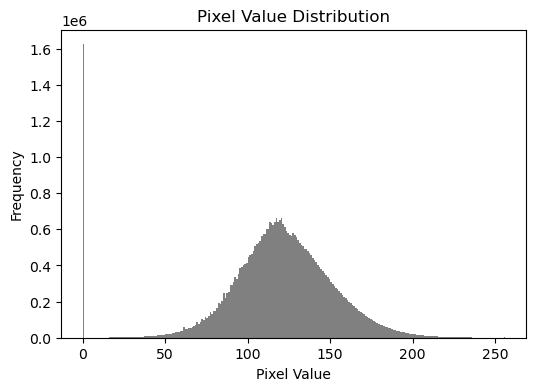

In [5]:
# This section of the code plots a channel by channel distribution of the prewhitened images  

input_dir4 = "Prewhitened_Patches"

pixel_values = []

for filename in os.listdir(input_dir4):
   
    image = cv2.imread(os.path.join(input_dir4, filename), cv2.IMREAD_GRAYSCALE)
   
    pixel_values.extend(image.flatten())

# Subplot creation 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plotting
ax.hist(pixel_values, bins=256, range=(0, 256), color='gray')
ax.set_title('Pixel Value Distribution')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')

plt.show()


The pixel intensity distribution plot shows the distribution of pixel values across all the prewhitened patches. The x-axis represents the range of pixel values, which in this case is from 0 to 255 for grayscale. The y-axis represents the frequency of each pixel value in the patches. The distribution plot shows a normal distribution,  the pixel values range from ~50 to ~200, and the central value is ~130.  The normal distribution curve is desired, as it means that the images have good contrast and dynamic range of pixel values.

There is a really high frequency of zero pixels which is due to some prewhitened images being completely black. We are not entirely sure why we are getting black images. Initially, I thought it could be an indication of some mathematical instability due to being divided by zero so I added a check using the denominator variable. This resolves any issues with instability but we still see some black images

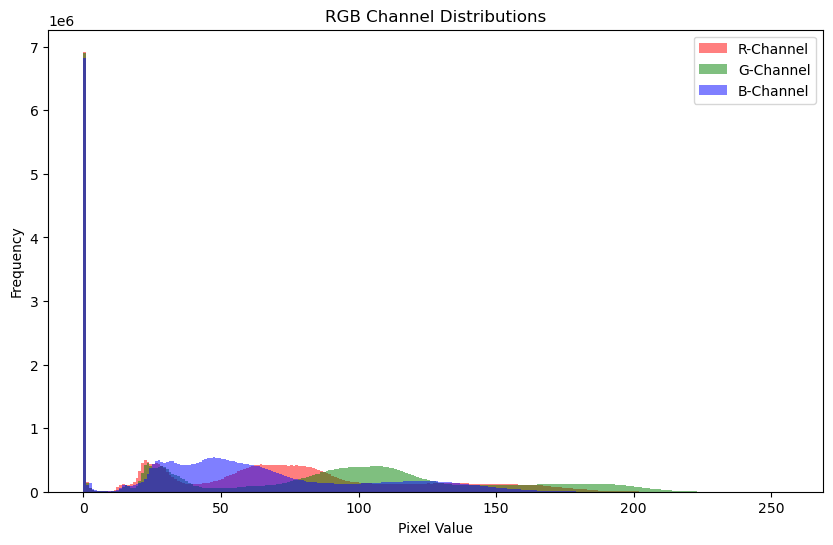

In [6]:
# This section of the code plots the channel by channel distribution of the Patches of images before performing ZCA whitening
# I am plotting these patches channel by channel out of curiousity 
input_dir5 = 'Patches_of_Transformed_leaves'

r_channel_values = []
g_channel_values = []
b_channel_values = []

for filename in os.listdir(input_dir5):

    image = cv2.imread(os.path.join(input_dir5, filename))

    b, g, r = cv2.split(image)

    r_channel_values.extend(r.flatten())
    g_channel_values.extend(g.flatten())
    b_channel_values.extend(b.flatten())

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the R-channel distribution; using 0.5 alpha to make semi transparent
ax.hist(r_channel_values, bins=256, range=(0, 256), color='red', alpha=0.5, label='R-Channel')
# Plotting the G-channel distribution
ax.hist(g_channel_values, bins=256, range=(0, 256), color='green', alpha=0.5, label='G-Channel')
# Plotting the B-channel distribution
ax.hist(b_channel_values, bins=256, range=(0, 256), color='blue', alpha=0.5, label='B-Channel')

ax.set_title('RGB Channel Distributions')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()


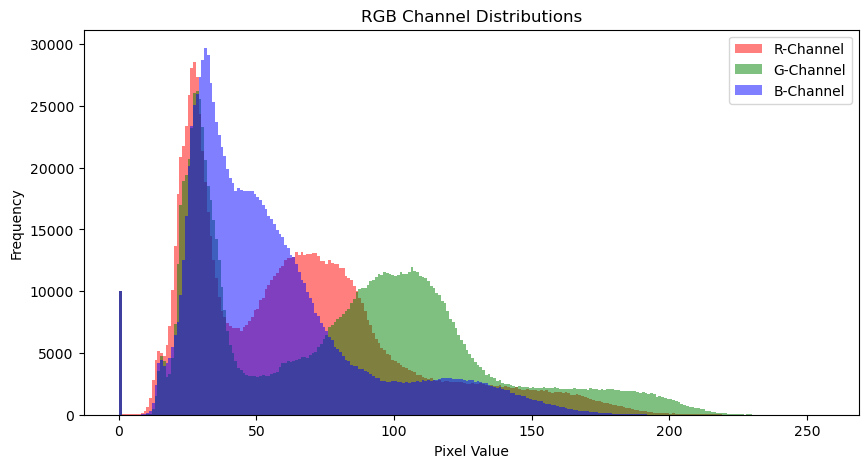

In [7]:
# This section of the code plots channel by channel distribution of the orignal images
#input_dir = 'AgandBio\leaves'

r_channel_values = []
g_channel_values = []
b_channel_values = []

for filename in os.listdir(input_dir):

    image = cv2.imread(os.path.join(input_dir, filename))

    b, g, r = cv2.split(image)

    r_channel_values.extend(r.flatten())
    g_channel_values.extend(g.flatten())
    b_channel_values.extend(b.flatten())

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the R-channel distribution, same as before choose 0.5 alpha 
ax.hist(r_channel_values, bins=256, range=(0, 256), color='red', alpha=0.5, label='R-Channel')
# Plot the G-channel distribution
ax.hist(g_channel_values, bins=256, range=(0, 256), color='green', alpha=0.5, label='G-Channel')
# Plot the B-channel distribution
ax.hist(b_channel_values, bins=256, range=(0, 256), color='blue', alpha=0.5, label='B-Channel')

ax.set_title('RGB Channel Distributions')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()


This plot shows the pixel intensities of the original image. 